In [1]:
# DATA

import pandas as pd
import stan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from sklearn.model_selection import train_test_split


# stan problems
import nest_asyncio
nest_asyncio.apply()


In [2]:
url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
data = pd.read_csv(url)

# god is dead, force a normal
data['smoker'] = data['smoker'].map({'yes': 1, 'no': 0})

X = data[['bmi', 'age', 'children', 'smoker']].values
y = data['charges'].values


# Standardize predictors (mean=0, sd=1)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std
X_std = X.std(axis=0)
continuous_vars = data[['bmi', 'age', 'children']]
continuous_vars_standardized = (continuous_vars - continuous_vars.mean()) / continuous_vars.std()

X_standardized = np.hstack([continuous_vars_standardized, data[['smoker']].values])

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42)


In [3]:
stan_data = {
  'N': X_train.shape[0],
  'M': X_train.shape[1],
  'X': X_train,
  'y': y_train,
  'N_test': X_test.shape[0],
  'X_test': X_test
}

with open('multiple_regression.stan', 'r') as f:
    stan_code = f.read()
    
posterior = stan.build(stan_code, data=stan_data, random_seed=42)

Building...



Building: found in cache, done.

Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.00019 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.9 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_gquumxii/model_rezrxovk.stan', line 21, column 2 to column 38)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 0.000184 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.84 seconds.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha   -0.396  0.017  -0.430   -0.364        0.0      0.0    9346.0   
beta[0]  0.165  0.016   0.136    0.195        0.0      0.0   10163.0   
beta[1]  0.298  0.016   0.269    0.328        0.0      0.0   10522.0   
beta[2]  0.042  0.015   0.014    0.072        0.0      0.0   10397.0   
beta[3]  1.951  0.039   1.875    2.020        0.0      0.0    9719.0   
sigma    0.507  0.011   0.486    0.527        0.0      0.0    9713.0   

         ess_tail  r_hat  
alpha      6429.0    1.0  
beta[0]    6037.0    1.0  
beta[1]    5893.0    1.0  
beta[2]    5565.0    1.0  
beta[3]    6633.0    1.0  
sigma      6303.0    1.0  


Text(0.5, 1.0, 'Posterior Distributions of Beta Coefficients')

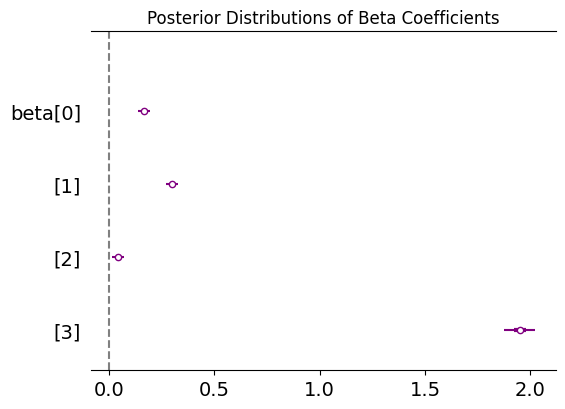

In [4]:

fit = posterior.sample(num_chains=4, num_samples=2000)
y_pred_samples = fit['y_pred']

# shape --> [num_draws, N_test]
# Adjust y_test to match y_pred_samples shape (268, 8000) and compute RMSE per draw <-- Chatgpt did this because everything kep breaking, help
rmse_samples = np.sqrt(np.mean((y_pred_samples - y_test[:, None])**2, axis=0))
rmse_mean = rmse_samples.mean()
rmse_ci = np.percentile(rmse_samples, [2.5, 97.5])

idata = az.from_pystan(posterior=fit)
print(az.summary(idata, var_names=['alpha', 'beta', 'sigma']))

az.plot_forest(idata, var_names=['beta'], combined=True, colors="purple")
plt.axvline(0, linestyle='--', color='gray')
plt.title("Posterior Distributions of Beta Coefficients")